### 1. Import IMDB-data

In [37]:
# In a notebook cell (run once per kernel)
import os, sys
PROJECT_ROOT = os.path.abspath("..")  # if the notebook is in notebooks/, go up one level
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt, load_imdb
from torch_geometric.transforms import ToUndirected

data = load_hetero_pt()

data = ToUndirected()(data)

### 1.1 Quick sanity check of the data

In [ ]:
delete = ['week', 'domain', 'stem', 'email_domain']

for node in delete:
    del data[node]

for edge_type in list(data.edge_types):
    for node in delete:
        if node in edge_type:   # edge_type is a tuple: (src, rel, dst)
            del data[edge_type]


In [39]:
import torch

for ntype in data.node_types:
    if 'x' not in data[ntype]:
        continue

    x = data[ntype].x

    # 1) ensure float32
    if x.dtype != torch.float32:
        x = x.float()

    # 2) standardize features: zero mean, unit variance per feature dim
    mu = x.mean(dim=0)
    sigma = x.std(dim=0).clamp_min(1e-6)  # avoid division by zero

    data[ntype].x = (x - mu) / sigma

In [40]:
# ---------- Print a quick summary ----------
print("=== Data loaded ===")
print("Metadata (node_types, edge_types):")
print(data.metadata())  # (['movie','director','actor'], [('movie','to','director'), ...])

# Basic counts per node type
print("\nNode counts:")
for ntype in data.node_types:
    print(f"  {ntype:>12}: {data[ntype].num_nodes}")

# Basic counts per edge type
print("\nEdge counts:")
for et in data.edge_types:
    E = data[et].edge_index.size(1)
    print(f"  {et}: {E}")

# Peek at feature availability
print("\nFeature tensors present?")
for ntype in data.node_types:
    has_x = 'x' in data[ntype]
    shape = tuple(data[ntype].x.shape) if has_x else None
    print(f"  {ntype:>12}: x present? {has_x}, shape={shape}")

=== Data loaded ===
Metadata (node_types, edge_types):
(['email', 'sender', 'receiver', 'url'], [('email', 'has_sender', 'sender'), ('email', 'has_receiver', 'receiver'), ('email', 'has_url', 'url'), ('sender', 'rev_has_sender', 'email'), ('receiver', 'rev_has_receiver', 'email'), ('url', 'rev_has_url', 'email')])

Node counts:
         email: 29399
        sender: 27424
      receiver: 1856
           url: 13734

Edge counts:
  ('email', 'has_sender', 'sender'): 29397
  ('email', 'has_receiver', 'receiver'): 33100
  ('email', 'has_url', 'url'): 21790
  ('sender', 'rev_has_sender', 'email'): 29397
  ('receiver', 'rev_has_receiver', 'email'): 33100
  ('url', 'rev_has_url', 'email'): 21790

Feature tensors present?
         email: x present? True, shape=(29399, 391)
        sender: x present? True, shape=(27424, 2)
      receiver: x present? True, shape=(1856, 2)
           url: x present? True, shape=(13734, 2)


In [41]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
                      else "cpu")
print(DEVICE)
# Pick any integer seed
TORCH_SEED = 42

mps


In [ ]:
# Train again with stronger negatives; keep your fanout as before
import os, sys
PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.train import run_training
from src.eval_link import collect_scores, topk_eval_with_splits


model, predictor, loaders, splits = run_training(
    DEVICE,
    TORCH_SEED,
    data,
    primary_ntype='email',
    hidden=128, out_dim=128, layers=2, dropout=0.1,
    neg_ratio=1.0,
    batch_size=512, fanout=[2, 1],     # 2-hop
    val_ratio=0.1, test_ratio=0.1, epochs=5, lr=5e-4, wd=5e-4,
    score_head='dot',
)


Metadata: (['email', 'sender', 'receiver', 'url'], [('email', 'has_sender', 'sender'), ('email', 'has_receiver', 'receiver'), ('email', 'has_url', 'url'), ('sender', 'rev_has_sender', 'email'), ('receiver', 'rev_has_receiver', 'email'), ('url', 'rev_has_url', 'email')])
Supervised edge types: [('email', 'has_sender', 'sender'), ('email', 'has_receiver', 'receiver'), ('email', 'has_url', 'url'), ('sender', 'rev_has_sender', 'email'), ('receiver', 'rev_has_receiver', 'email'), ('url', 'rev_has_url', 'email')]
Build train graph!
Build link loaders!
Starting training!
[Epoch 01] train loss 5.9529 acc 0.840 | val loss 3.2334 acc 0.834
[Epoch 02] train loss 1.8579 acc 0.911 | val loss 1.5855 acc 0.847
[Epoch 03] train loss 1.0342 acc 0.934 | val loss 2.4123 acc 0.854


In [26]:
# AUROC/AP (as before)
scores = collect_scores(DEVICE, model, predictor, loaders['test'])
print("TEST AUROC/AP per relation:")
for et, s in scores.items():
    print(et, s)

# Recall@K with cosine and larger K (easier for many-to-many like movie→actor)
res_k50_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=50, use_dot=False)
print("\nRecall@50 (cosine) per relation:")
for et, m in res_k50_cos.items():
    print(et, m)

TEST AUROC/AP per relation:
('email', 'has_sender', 'sender') {'auroc': 0.9500408730497315, 'ap': 0.9323557072141363}
('email', 'has_url', 'url') {'auroc': 0.9689400323206981, 'ap': 0.9609420521990593}
('sender', 'rev_has_sender', 'email') {'auroc': 0.9727359218942125, 'ap': 0.969340107917377}
('url', 'rev_has_url', 'email') {'auroc': 0.9812832281776842, 'ap': 0.9792087863021559}

Recall@50 (cosine) per relation:
('email', 'has_sender', 'sender') {'recall@K': 0.08097992837429047, 'MRR': 0.15982213616371155, 'K': 50, 'n_eval_sources': 2939}
('email', 'has_url', 'url') {'recall@K': 0.3188334107398987, 'MRR': 0.2242322564125061, 'K': 50, 'n_eval_sources': 2023}
('sender', 'rev_has_sender', 'email') {'recall@K': 0.5827186703681946, 'MRR': 0.34929805994033813, 'K': 50, 'n_eval_sources': 2847}
('url', 'rev_has_url', 'email') {'recall@K': 0.44234800338745117, 'MRR': 0.21972514688968658, 'K': 50, 'n_eval_sources': 1908}


In [27]:
import torch
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])
email_vecs = h_train['email']
url_vecs = h_train['url']

print("Email embedding L2 norms:")
print(email_vecs.norm(dim=1).mean(), email_vecs.norm(dim=1).max())

print("URL embedding L2 norms:")
print(url_vecs.norm(dim=1).mean(), url_vecs.norm(dim=1).max())

Email embedding L2 norms:
tensor(15.3280, device='mps:0') tensor(259.3651, device='mps:0')
URL embedding L2 norms:
tensor(8.4053, device='mps:0') tensor(208.9673, device='mps:0')


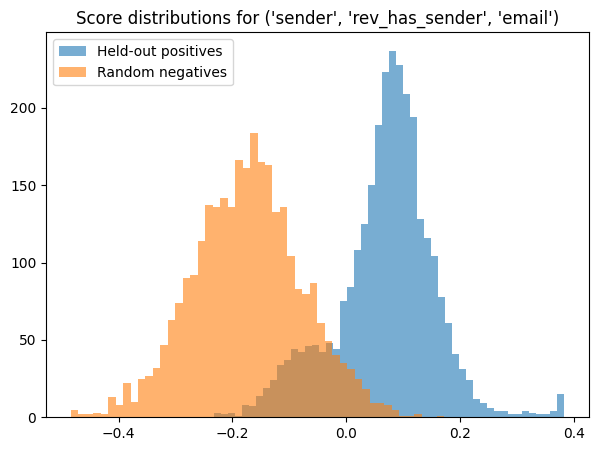

email_id: 23
Top-20 url ids: [18102, 27303, 25642, 3940, 5057, 17951, 2217, 27333, 27165, 24028, 22136, 16158, 5033, 14836, 25988, 22379, 2215, 25113, 19072, 27040]
Is held-out true?: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [31]:
import os, sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import topk_for_source

# --- Embed on the train_graph (leakage-safe) ---
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])

et = ('sender', 'rev_has_sender', 'email')

# L2-normalize embeddings so dot products ≈ cosine
S = F.normalize(h_train[et[0]], p=2, dim=1)
D = F.normalize(h_train[et[2]], p=2, dim=1)

# For analysis, move everything to CPU to avoid MPS quirks
S = S.cpu()
D = D.cpu()

# Held-out positive edges for this relation (from TEST split)
pos = splits['test_pos'][et]                # [2, E_test]

# Scores for true (held-out) edges
pos_scores = (S[pos[0]] * D[pos[1]]).sum(dim=1).numpy()

# Scores for random negative pairs
g = torch.Generator().manual_seed(0)
neg_src = torch.randint(0, S.size(0), (len(pos_scores),), generator=g)
neg_dst = torch.randint(0, D.size(0), (len(pos_scores),), generator=g)
neg_scores = (S[neg_src] * D[neg_dst]).sum(dim=1).numpy()

plt.figure(figsize=(7, 5))
plt.hist(pos_scores, bins=50, alpha=0.6, label='Held-out positives')
plt.hist(neg_scores, bins=50, alpha=0.6, label='Random negatives')
plt.title(f"Score distributions for {et}")
plt.legend()
plt.show()

# --- Qualitative Top-K example (still fine to use h_train on DEVICE) ---
sources_with_pos = splits['test_pos'][et][0].unique()
src_id = int(sources_with_pos[0])  # pick a valid email id

top_ids, top_scores = topk_for_source(h_train, et, src_id, K=20, cosine=True)
true_dests = set(
    splits['test_pos'][et][1][splits['test_pos'][et][0] == src_id].cpu().tolist()
)
print("email_id:", src_id)
print("Top-20 url ids:", top_ids)
print("Is held-out true?:", [i in true_dests for i in top_ids])


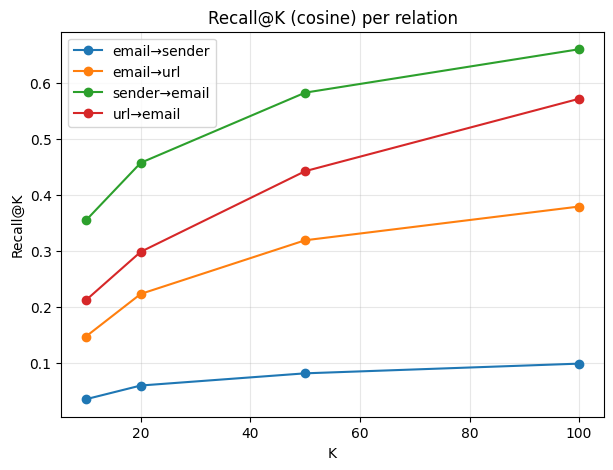


Recall@50: dot vs cosine
('email', 'has_sender', 'sender'): dot=0.066 | cosine=0.081
('email', 'has_url', 'url'): dot=0.276 | cosine=0.319
('sender', 'rev_has_sender', 'email'): dot=0.484 | cosine=0.583
('url', 'rev_has_url', 'email'): dot=0.410 | cosine=0.442

Qualitative Top-20 for source email id=31 (cosine):
Top-20 dest ids: [9557, 8962, 11660, 12658, 7196, 12982, 1579, 12504, 4686, 9210, 1137, 12880, 319, 13253, 10501, 11099, 11897, 10513, 10956, 10609]
Is held-out true?: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [32]:
# === Light suggestions: recall curves, cosine vs dot, qualitative Top-K, optional fine-tune ===
import torch, matplotlib.pyplot as plt
import os, sys
PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import collect_scores, topk_eval_with_splits, topk_for_source, recall_at_k_mrr

# --- 1) Recall@K curves (cosine) ---
K_list = [10, 20, 50, 100]
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])  # leakage-safe embeddings
ets = splits['sup_ets']

recall_curves = {et: [] for et in ets}
for et in ets:
    for K in K_list:
        res = recall_at_k_mrr(h_train, et, splits['test_pos'][et], K=K, use_dot=False)
        recall_curves[et].append(res['recall@K'])

# Plot curves
plt.figure(figsize=(7,5))
for et, vals in recall_curves.items():
    label = f"{et[0]}→{et[2]}"
    plt.plot(K_list, vals, marker='o', label=label)
plt.xlabel("K"); plt.ylabel("Recall@K"); plt.title("Recall@K (cosine) per relation"); plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- 2) Dot vs Cosine table at K=50 ---
def recall_at_k_for_metric(h, et, K, use_dot):
    return recall_at_k_mrr(h, et, splits['test_pos'][et], K=K, use_dot=use_dot)['recall@K']

print("\nRecall@50: dot vs cosine")
for et in ets:
    r_dot = recall_at_k_for_metric(h_train, et, K=50, use_dot=True)
    r_cos = recall_at_k_for_metric(h_train, et, K=50, use_dot=False)
    print(f"{et}: dot={r_dot:.3f} | cosine={r_cos:.3f}")

# --- 3) Qualitative Top-K (pick a source that has held-out positives) ---
et_demo = ('email', 'has_url', 'url')  # change if you want a different relation
srcs_with_pos = splits['test_pos'][et_demo][0].unique()
if len(srcs_with_pos) > 0:
    src_id = int(srcs_with_pos[0])  # first valid source
    top_ids, top_scores = topk_for_source(h_train, et_demo, src_id, K=20, cosine=True)
    true_dests = set(splits['test_pos'][et_demo][1][splits['test_pos'][et_demo][0]==src_id].cpu().tolist())
    print(f"\nQualitative Top-20 for source {et_demo[0]} id={src_id} (cosine):")
    print("Top-20 dest ids:", top_ids)
    print("Is held-out true?:", [i in true_dests for i in top_ids])
else:
    print(f"No sources with held-out positives found for {et_demo}")

# --- 4) (Optional) Fine-tune a bit more, then re-run the same checks ---
# Uncomment to do 2 more epochs with same loaders/optimizer settings:
# opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# for e in range(2):
#     tr_loss, tr_acc = train_epoch(model, predictor, opt, loaders['train'])
#     va_loss, va_acc = eval_epoch(model, predictor, loaders['val'])
#     print(f"[Finetune {e+1}/2] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
# # Recompute embeddings & recall curves if you fine-tuned:
# # h_train = embed_with_graph(model, splits['train_graph'])
# # (then rerun the recall curve and Top-K blocks above)


In [ ]:
# --- Export embeddings for the primary node type (e.g., 'movie') ---


# Use the splits you already have (leakage-safe train_graph)
z = export_embeddings(model, splits['train_graph'], primary_ntype='movie', layers=2, batch_size=4096)

# L2-normalize (cosine-friendly)
z = torch.nn.functional.normalize(z, p=2, dim=1)  # [N, d]


In [ ]:
def knn_graph_cosine(z, k=30, chunk=8192):
    """
    Returns (indices, sims), where:
      indices: [N, k] int64 neighbor IDs (excluding self)
      sims:    [N, k] float32 cosine sims corresponding to indices
    """
    z = torch.nn.functional.normalize(z, p=2, dim=1)
    N, d = z.shape
    all_idx = []
    all_sim = []
    for start in range(0, N, chunk):
        end = min(start+chunk, N)
        block = z[start:end]                               # [B, d]
        sims = block @ z.T                                 # [B, N]
        sims[:, start:end] = -1.0                          # exclude self-range; will be masked out by topk anyway
        vals, idx = torch.topk(sims, k=k, dim=1)           # [B, k]
        all_idx.append(idx.cpu())
        all_sim.append(vals.cpu())
    return torch.vstack(all_idx), torch.vstack(all_sim)

knn_idx, knn_sim = knn_graph_cosine(z, k=30)  # typical k=15~50


In [ ]:
# pip install hdbscan (once)
import numpy as np
try:
    import hdbscan
except ImportError:
    raise RuntimeError("Please `pip install hdbscan` to use HDBSCAN.")

def cluster_hdbscan(z, min_cluster_size=15, min_samples=None, metric='euclidean'):
    # HDBSCAN works in distance space; use euclidean on normalized z (cosine≈euclid on unit vectors)
    Z = z.numpy() if isinstance(z, torch.Tensor) else z
    clf = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric)
    labels = clf.fit_predict(Z)    # -1 are noise points
    probs  = clf.probabilities_
    return labels, probs, clf

labels_hdb, probs_hdb, hdb = cluster_hdbscan(z, min_cluster_size=20, min_samples=10)


In [ ]:
# pip install igraph leidenalg
import igraph as ig
import leidenalg as la

def leiden_from_knn(knn_idx, knn_sim=None, resolution=1.0, weighted=True):
    """
    Build an undirected graph from kNN edges and run Leiden.
    """
    N = knn_idx.shape[0]
    # Build edge list (i < j to avoid duplicates)
    src = np.repeat(np.arange(N), knn_idx.shape[1])
    dst = knn_idx.reshape(-1)
    edge_pairs = np.stack([src, dst], axis=1)
    # Make undirected unique edges
    edge_pairs = np.sort(edge_pairs, axis=1)
    edge_pairs = np.unique(edge_pairs, axis=0)
    g = ig.Graph(n=N, edges=edge_pairs.tolist(), directed=False)

    weights = None
    if weighted and knn_sim is not None:
        # Map weights per edge; we take max of (i->j, j->i) if duplicates happened before unique
        sim_map = {}
        for i in range(N):
            for k, j in enumerate(knn_idx[i]):
                a, b = (i, int(j))
                key = (min(a,b), max(a,b))
                w = float(knn_sim[i, k])
                sim_map[key] = max(sim_map.get(key, -1e9), w)
        weights = [sim_map[(a,b)] for a,b in edge_pairs]

    part = la.find_partition(g, la.RBConfigurationVertexPartition, weights=weights, resolution_parameter=resolution)
    return np.array(part.membership), g, part

labels_lei, g_lei, part_lei = leiden_from_knn(knn_idx.numpy(), knn_sim.numpy(), resolution=1.0, weighted=True)


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def intrinsic_metrics(z, labels, max_points=20000):
    # ignore noise label -1 for silhouette if present
    z_np = z.numpy() if isinstance(z, torch.Tensor) else z
    idx = np.arange(len(labels))
    mask = labels != -1
    use = idx[mask]
    if len(use) < 2 or len(np.unique(labels[mask])) < 2:
        return {'silhouette': np.nan, 'calinski_harabasz': np.nan, 'davies_bouldin': np.nan}
    # downsample for speed
    if len(use) > max_points:
        use = np.random.RandomState(0).choice(use, size=max_points, replace=False)
    s = silhouette_score(z_np[use], labels[use], metric='euclidean')
    ch = calinski_harabasz_score(z_np[use], labels[use])
    db = davies_bouldin_score(z_np[use], labels[use])
    return {'silhouette': float(s), 'calinski_harabasz': float(ch), 'davies_bouldin': float(db)}

m_in_hdb = intrinsic_metrics(z, labels_hdb)
m_in_lei = intrinsic_metrics(z, labels_lei)
print("HDBSCAN intrinsic:", m_in_hdb)
print("Leiden   intrinsic:", m_in_lei)


In [ ]:
def cluster_purity_movie_director(labels, data, primary_ntype='movie'):
    """
    For each movie, get its directors. For each cluster, take the majority director and compute purity.
    Returns micro- and macro-averaged purity (exclude noise cluster -1).
    """
    ei = data[('movie','to','director')].edge_index  # [2, E]
    m, d = ei[0].cpu().numpy(), ei[1].cpu().numpy()
    N = data[primary_ntype].num_nodes
    labels = np.asarray(labels)
    # build directors-per-movie lists
    from collections import defaultdict, Counter
    dirs_by_movie = defaultdict(list)
    for mi, di in zip(m, d):
        dirs_by_movie[int(mi)].append(int(di))
    # per-cluster majority director
    cluster_to_movies = {}
    for mi in range(N):
        c = int(labels[mi])
        if c == -1:   # skip noise
            continue
        cluster_to_movies.setdefault(c, []).append(mi)
    if not cluster_to_movies:
        return {'micro_purity': np.nan, 'macro_purity': np.nan, 'n_clusters': 0}

    purities = []
    total = 0
    correct = 0
    for c, movies in cluster_to_movies.items():
        # count directors across all movies in cluster
        cnt = Counter()
        for mi in movies:
            cnt.update(dirs_by_movie.get(mi, []))
        if len(cnt) == 0:
            purities.append(0.0)
            continue
        maj_dir, maj_count = cnt.most_common(1)[0]
        # total assignments = number of (movie, director) pairs in cluster
        cluster_total = sum(cnt.values())
        purities.append(maj_count / cluster_total)
        total += cluster_total
        correct += maj_count
    micro = correct / total if total > 0 else np.nan
    macro = float(np.mean(purities)) if purities else np.nan
    return {'micro_purity': micro, 'macro_purity': macro, 'n_clusters': len(cluster_to_movies)}

pur_hdb = cluster_purity_movie_director(labels_hdb, data, 'movie')
pur_lei = cluster_purity_movie_director(labels_lei, data, 'movie')
print("HDBSCAN movie→director purity:", pur_hdb)
print("Leiden   movie→director purity:", pur_lei)


In [ ]:
# pip install scikit-learn (usually present)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def stability_ari_nmi(z, cluster_fn, n_runs=3):
    parts = []
    for s in range(n_runs):
        np.random.seed(42 + s)
        torch.manual_seed(42 + s)
        labels, *_ = cluster_fn()
        parts.append(np.asarray(labels))
    # pairwise ARI/NMI
    aris, nmis = [], []
    for i in range(n_runs):
        for j in range(i+1, n_runs):
            aris.append(adjusted_rand_score(parts[i], parts[j]))
            nmis.append(normalized_mutual_info_score(parts[i], parts[j]))
    return {'ARI_mean': float(np.mean(aris)), 'NMI_mean': float(np.mean(nmis))}

# Example: HDBSCAN stability over different min_samples
stab_hdb = stability_ari_nmi(
    z,
    cluster_fn=lambda: cluster_hdbscan(z, min_cluster_size=20, min_samples=np.random.randint(5, 15)),
    n_runs=3
)
print("HDBSCAN stability:", stab_hdb)


In [ ]:
# pip install umap-learn
import umap
def umap_embed(z, n_neighbors=30, min_dist=0.1, random_state=42):
    Z = z.numpy() if isinstance(z, torch.Tensor) else z
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    return reducer.fit_transform(Z)  # [N, 2]

um = umap_embed(z, n_neighbors=30, min_dist=0.05)
# Plot with your favorite tool; color by labels_hdb or labels_lei
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.scatter(um[:,0], um[:,1], c=labels_hdb, s=5, cmap='tab20', alpha=0.9)
plt.title("UMAP of movie embeddings — HDBSCAN clusters")
plt.show()


In [ ]:
# 1) Export embeddings (leakage-safe) and normalize
z = export_embeddings(model, splits['train_graph'], primary_ntype='movie', layers=2, batch_size=4096)
z = torch.nn.functional.normalize(z, p=2, dim=1)

# 2) k-NN graph
knn_idx, knn_sim = knn_graph_cosine(z, k=30)

# 3) Clustering
labels_hdb, probs_hdb, _ = cluster_hdbscan(z, min_cluster_size=20, min_samples=10)
labels_lei, g_lei, part_lei = leiden_from_knn(knn_idx.numpy(), knn_sim.numpy(), resolution=1.0, weighted=True)

# 4) Metrics
print("Intrinsic (HDBSCAN):", intrinsic_metrics(z, labels_hdb))
print("Intrinsic (Leiden):  ", intrinsic_metrics(z, labels_lei))
print("Purity (movie→director, HDBSCAN):", cluster_purity_movie_director(labels_hdb, data))
print("Purity (movie→director, Leiden): ", cluster_purity_movie_director(labels_lei, data))

# 5) Stability (optional)
stab_hdb = stability_ari_nmi(z, lambda: cluster_hdbscan(z, 20, np.random.randint(5, 15)), n_runs=3)
print("HDBSCAN stability:", stab_hdb)

# 6) UMAP (optional)
um = umap_embed(z, n_neighbors=30, min_dist=0.05)
plt.figure(figsize=(7,6))
plt.scatter(um[:,0], um[:,1], c=labels_hdb, s=5, cmap='tab20', alpha=0.9)
plt.title("UMAP of movie embeddings — HDBSCAN clusters")
plt.show()
